In [1]:
import netCDF4 as nc
import os
import numpy as np
import julian
import numpy.ma as ma

Todo list:
- Get the ocean state as variables for Linear Regression
- Try regularized model
- Improve ONI to 3.4 region
- Try neural net
- Try RNN

In [2]:
os.listdir('data')[0]

'wdir_xyt_5day.cdf'

In [3]:
import subprocess

for subfolder in os.listdir('data'):
    if subfolder.find(".")<0 :
        contents = os.listdir("data/" +subfolder)
        print(subfolder)
        print(contents[0:5])
        print(len(contents))
        if len(contents) <5:
            #identify the file
            target = 0
            for i,x in enumerate(contents):
                if x.find(".tar")>0:
                    target=i
            os.system("tar -xvf data/"+subfolder+"/'"+contents[target]+"' -C data/"+subfolder)
        contents = os.listdir("data/" +subfolder)
        if sum([i.find(".cdf.gz")>0 for i in contents])>0:
            os.system("gunzip data/"+subfolder+"/*.gz")

sst_anom
['README_sst.txt', 'sst_anom_0n110w_5day.cdf', 'sst_anom_0n156e_5day.cdf', 'read_netcdf.f', 'sst_anom_0n165e_5day.cdf']
17


In [4]:
path_to_anomaly = "data/sst_anom"
path = path_to_anomaly
anomaly_files = [path+"/" + file for file in os.listdir(path) if file.find(".cdf")>0]

In [5]:
anomalies = [f for f in anomaly_files if f.find("anom_")>0]
from netCDF4 import MFDataset
from netCDF4 import Dataset

anomalies_ds = MFDataset(anomalies, aggdim = 'time')

In [6]:
times_set = set(anomalies_ds['time'][:])
times = anomalies_ds['time'][:]
T_25 = anomalies_ds['T_25'][:]
times[0], times[-1]

(2444306, 2457730)

In [7]:
all_times = np.array(sorted(times_set))
dates = np.array([julian.from_jd(t, 'jd') for t in all_times])
month_key = [(d.year, d.month) for d in dates]
month_key_unique = sorted(set(month_key))

In [8]:
#Process:
'''
For each label in month_key_unique, get it and the previous two keys.
'''
running_averages = []
for i in range(2, len(month_key_unique)):    
    months = [month_key_unique[i-j] for j in range(3)]
    mask = [m in months for m in month_key]
    time_window = set(all_times[mask])
    include = [t in time_window for t in times]
    to_average = [T_25[i] for i in range(len(T_25)) if include[i] and T_25[i]<1e10]
    running_averages.append(np.mean(to_average))
running_averages = np.array(running_averages)

/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
data_items = {}
for subfolder in os.listdir('data'):
    if subfolder.find(".cdf")>0:
        if subfolder.find("anom")<10000:
            print(subfolder)
            path = "data/"+subfolder

            d = Dataset(path)
            dims = d.dimensions
            vals = d.variables.keys()
            values = {k:d[k][:] for k in vals}
            data_items[subfolder]=values
cdf_files = ["data/" + file for file in os.listdir("data") if file.find(".cdf")>0]
data_files = [Dataset(c) for c in cdf_files]
cdf_files

wdir_xyt_5day.cdf
sss_xyt_5day.cdf
cur_xyzt_5day.cdf
sst_anom_xyt_5day.cdf
vwnd_xyt_5day.cdf
bp_xyt_5day.cdf
wspd_xyt_5day.cdf
sst_xyt_5day.cdf
uwnd_xyt_5day.cdf


['data/wdir_xyt_5day.cdf',
 'data/sss_xyt_5day.cdf',
 'data/cur_xyzt_5day.cdf',
 'data/sst_anom_xyt_5day.cdf',
 'data/vwnd_xyt_5day.cdf',
 'data/bp_xyt_5day.cdf',
 'data/wspd_xyt_5day.cdf',
 'data/sst_xyt_5day.cdf',
 'data/uwnd_xyt_5day.cdf']

In [10]:
#Data requirements:
#All sites in one file
#One variable
#Select all sites
#Netcdf, 4 byte, julian
#1979, Jan 20.
#5-day

In [11]:
fills = np.array([d['time'][:].fill_value for d in data_files])
start_time = 2443895
julian.from_jd(start_time, 'jd')
mod_ = start_time*(fills > 1e10)
fixed_times = [d['time'][:] for d in data_files]+mod_
to_find = 2450000
finding_values = [list(np.array(d)>to_find).index(True) for d in fixed_times]
#Check if it's less than 0 to see if it's 'missing'

<ipython-input-11-e4cb28bdfdd5>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fixed_times = [d['time'][:] for d in data_files]+mod_


In [12]:
def find_data_indices(date, arrays=fixed_times):
    return [list(np.array(d)>date).index(True) for d in arrays]

In [13]:
#Okay. I've got it all on the same scale. Next step- getting a specific day.


In [14]:

starting_point = 82


start_x = find_data_indices(all_times[starting_point])
#What files to use?
features_select = [ False, False, True, False, True,  False, False, True, True,]
start_x

[1, 0, 73, 1, 1, 0, 1, 1, 1]

In [15]:
len(np.array(data_files)[features_select]), len(data_files)

(4, 9)

In [16]:
to_use = np.array(data_files)[features_select]
[print(k.variables.keys()) for k in to_use]
np.array(cdf_files)[features_select]

dict_keys(['lon', 'lat', 'depth', 'time2', 'time', 'U_320', 'V_321', 'S_300', 'D_310', 'QS_5300', 'QD_5310', 'SRC_6300'])
dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'WV_423', 'QWV_5423', 'SWV_6423'])
dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'T_20', 'QT_5020', 'ST_6020'])
dict_keys(['time', 'time2', 'depth', 'lat', 'lon', 'WU_422', 'QWU_5422', 'SWU_6422'])


array(['data/cur_xyzt_5day.cdf', 'data/vwnd_xyt_5day.cdf',
       'data/sst_xyt_5day.cdf', 'data/uwnd_xyt_5day.cdf'], dtype='<U26')

In [17]:
variables_we_want = [['U_320', 'V_321'], ['WV_423'], ['T_20'], ['WU_422']]
var_names = flat_list = [item for sublist in variables_we_want for item in sublist]

In [18]:
s_x = np.array(start_x)[features_select]

In [43]:
def process_ds(dataset, start_t_index, variables):
    #Start_T is an index.
    to_return = []
    for v in variables:
        if v == 'U_320' or v=='V_321':
            vals = dataset[v][:,:,(2,),start_t_index:]
            to_return.append(np.transpose(vals, [3, 2, 0, 1]))
        else:
            to_return.append(dataset[v][start_t_index:, :])
    return to_return

ds_array = [process_ds(to_use[i], s_x[i], v) for i,v in enumerate(variables_we_want)]
flattened_vars = [ma.masked_greater(item, 1e10) for sublist in ds_array for item in sublist]
max_len = max([len(i) for i in flattened_vars])

In [37]:
flattened_vars[0][0].mask

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True],
        

In [41]:
np.array([[[2, 3, 4], [1, 2, 3]], [[2, 3, 4], [1, 2, 3]]]).reshape(1, -1)

array([[2, 3, 4, 1, 2, 3, 2, 3, 4, 1, 2, 3]])

In [44]:
values = [[]]*max_len
masks = [[]]*max_len

for dtype in flattened_vars:
    for t, t_slice in enumerate(dtype):
        new_mask = t_slice.mask
        new_data =ma.filled(t_slice, 0)
        
        values[t].append(new_data.reshape(1, -1))
        masks[t].append(new_mask.reshape(1, -1))

mean_variables = np.array(values)
mean_variables_masked = np.array(masks)

X_ = np.append(mean_variables, mean_variables_masked, axis=1)

<ipython-input-44-46dd42462753>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mean_variables = np.array(values)


ValueError: could not broadcast input array from shape (210) into shape (1)

In [ ]:
masks

In [21]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


r2s = []
for delay in range(25, 365, 10):
    start_y = starting_point + delay//5

    y = []
    filt_y = []
    for time in all_times[start_y:]:
        mask = times==time
        ONI = np.mean(T_25[mask])
        if ONI is ma.masked:
            filt_y.append(False)
        else:
            filt_y.append(True)
        y.append(ONI)

    X = X_[0:len(y)]
    X = X[filt_y[0:len(X)]]
    y = ma.array(y)[filt_y]
    y = y[:len(X)]
    x_names = var_names + [name+"_mask" for name in var_names]
    X = pd.DataFrame(X, columns=x_names)
    
    X_model, X_validate, y_model, y_validate = train_test_split(X,y, test_size=0.25, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_model,y_model, test_size=0.25, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    r2s.append(r2_score(y_test, lr.predict(X_test)))

/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/solomon/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/solomon/anaconda3/envs/metis/

In [22]:
import matplotlib.pyplot as plt

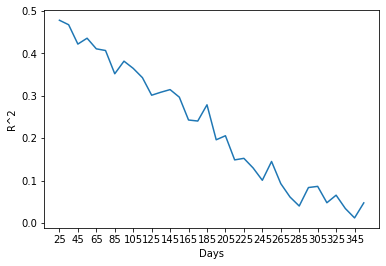

In [23]:
plt.plot(r2s)
plt.xticks(range(0, len(r2s), 2), range(25, 365, 20));
plt.xlabel("Days")
plt.ylabel("R^2");

In [24]:
lr.coef_

array([ 0.00274786,  0.00174172,  0.05547595,  0.04543904, -0.09557159,
        0.25643921,  0.25643921,  0.04446409,  0.39014619,  0.04446409])

In [25]:
'''
TODO
Average whole ocean, ignoring missing values to start.

Linear regression!
Time-series problem first.

Then- use each buoy as a feature, also mask.

Need which features are most informative.

NNs- start with vanilla NN, then after that's going, can start with RNN or 

'''



"\nTODO\nAverage whole ocean, ignoring missing values to start.\n\nLinear regression!\nTime-series problem first.\n\nThen- use each buoy as a feature, also mask.\n\nNeed which features are most informative.\n\nNNs- start with vanilla NN, then after that's going, can start with RNN or \n\n"